# --- PITCHER BREAKOUT PREDICTION PROJECT ---

## Importing libraries

In [3]:
import pandas as pd
import sklearn
import xgboost as xgb
import matplotlib.pyplot as plt 
import seaborn as sns

## Importing excel files 

In [5]:
Pitching_2023 = pd.read_excel('Pitching_2023.xlsx', skiprows=1)
Pitching_2024 = pd.read_excel('Pitching_2024.xlsx', skiprows=1)

print(Pitching_2023.head())

print(Pitching_2024.head())

  last_name, first_name  player_id  year  player_age   pa  p_era  xbadiff  \
0       Estévez, Carlos     608032  2023          30  281   3.90    0.020   
1         La Sorsa, Joe     686747  2023          25  145   4.41   -0.024   
2           Miley, Wade     489119  2023          36  490   3.14   -0.030   
3          López, Pablo     641154  2023          27  801   3.66    0.022   
4          Bolton, Cody     675989  2023          25  107   6.33    0.032   

   xslgdiff  barrel_batted_rate  oz_swing_percent  whiff_percent  
0     0.000                 6.6              27.1           27.5  
1    -0.020                 2.0              23.3           22.5  
2    -0.032                 7.6              26.7           19.1  
3     0.045                 6.3              34.3           30.3  
4     0.031                10.1              19.3           23.3  
  last_name, first_name  player_id  year  player_age   pa  p_era  xbadiff  \
0        Luzardo, Jesús     666200  2024          26  274 

## Fixing Names 

In [7]:
# For 2023
Pitching_2023[['Last', 'First']] = Pitching_2023['last_name, first_name'].str.split(', ', expand=True)
Pitching_2023['Name'] = Pitching_2023['First'] + ' ' + Pitching_2023['Last']
Pitching_2023 = Pitching_2023.drop(columns=['First', 'Last'])

# For 2024
Pitching_2024[['Last', 'First']] = Pitching_2024['last_name, first_name'].str.split(', ', expand=True)
Pitching_2024['Name'] = Pitching_2024['First'] + ' ' + Pitching_2024['Last']
Pitching_2024 = Pitching_2024.drop(columns=['First', 'Last'])

print(Pitching_2023.head())

print(Pitching_2024.head())

  last_name, first_name  player_id  year  player_age   pa  p_era  xbadiff  \
0       Estévez, Carlos     608032  2023          30  281   3.90    0.020   
1         La Sorsa, Joe     686747  2023          25  145   4.41   -0.024   
2           Miley, Wade     489119  2023          36  490   3.14   -0.030   
3          López, Pablo     641154  2023          27  801   3.66    0.022   
4          Bolton, Cody     675989  2023          25  107   6.33    0.032   

   xslgdiff  barrel_batted_rate  oz_swing_percent  whiff_percent  \
0     0.000                 6.6              27.1           27.5   
1    -0.020                 2.0              23.3           22.5   
2    -0.032                 7.6              26.7           19.1   
3     0.045                 6.3              34.3           30.3   
4     0.031                10.1              19.3           23.3   

             Name  
0  Carlos Estévez  
1    Joe La Sorsa  
2      Wade Miley  
3     Pablo López  
4     Cody Bolton  
  last_n

## Merging and Filtering 

In [9]:
merged_Pitching = pd.merge(Pitching_2023, Pitching_2024, on="Name", suffixes=("_2023", "_2024"))

pitchers_filtered = merged_Pitching[
    (merged_Pitching['player_age_2024'] <= 27) & 
    (merged_Pitching['pa_2023'] >= 150) & 
    (merged_Pitching['pa_2023'] <= 500) &
    (merged_Pitching['pa_2024'] >=150)  &
    (merged_Pitching['pa_2024'] <= 500)
]

## Making 2023 and 2024 dataframes and renaming variables for consistency 

In [11]:
Training_2023 = pitchers_filtered.copy()
Training_2024 = pitchers_filtered.copy()

Training_2023 = Training_2023.rename(columns={
    'xslgdiff_2023': 'xslgdiff',
    'xbadiff_2023': 'xbadiff'    
})

Training_2024 = Training_2024.rename(columns={
    'xslgdiff_2023': 'xslgdiff',
    'xbadiff_2023': 'xbadiff'    
})

X = Training_2023[['xslgdiff', 'xbadiff']]
y = Training_2023['p_era_2024']

## Building the model 

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=21) 
model.fit(X_train, y_train)

X_future = Training_2024[['xslgdiff', 'xbadiff']]
Training_2024['ERA_2025_pred'] = model.predict(X_future)

## Plotting the top 10 

<Axes: xlabel='ERA_2025_pred', ylabel='Name'>

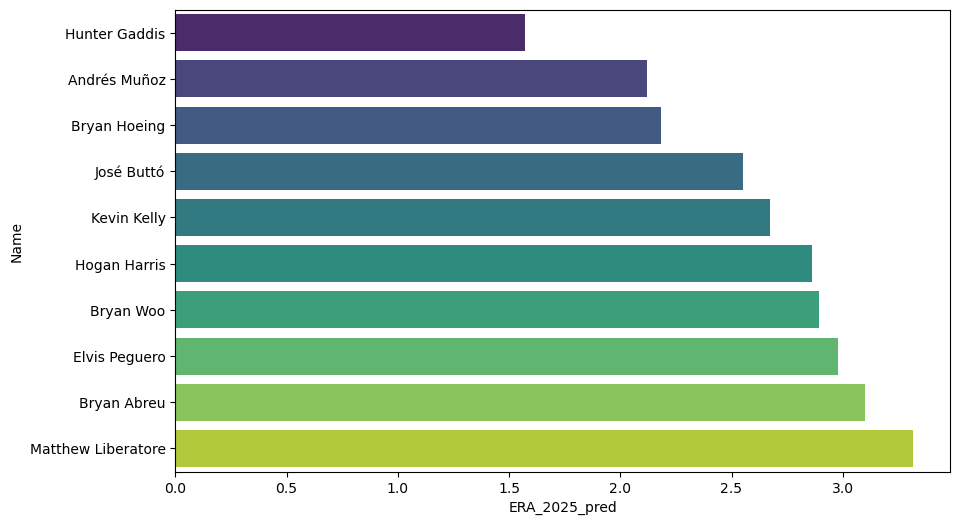

In [15]:
top_10 = Training_2024.sort_values('ERA_2025_pred').head(10)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.figure(figsize=(10,6))
sns.barplot(
    x='ERA_2025_pred',
    y='Name',
    data=top_10,
    palette='viridis',
    orient='h'
)

## Model Metrics 

In [17]:
importance_df = pd.DataFrame({
    'Feature': model.get_booster().feature_names,
    'Importance': model.feature_importances_
})

print(importance_df)

    Feature  Importance
0  xslgdiff    0.354736
1   xbadiff    0.645264
